In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture 
from collections import defaultdict
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score,mean_squared_error,davies_bouldin_score, calinski_harabasz_score, v_measure_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.random_projection import GaussianRandomProjection
from itertools import product
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# Load Visualization packages
# from yellowbrick.cluster import SilhouetteVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.cluster import InterclusterDistance
from scipy.stats import kurtosis,entropy

import time
import seaborn as sns

In [2]:
from tqdm import tqdm
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler

# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve,confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import train_test_split

In [4]:
import os
save_folder = "../figures/clustering/"
os.path.isdir(save_folder)

True

## Prepare the dataset : Heart Disease


In [5]:
filename = '../datasets/heart.csv'
df = pd.read_csv(filename)

In [6]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
# creating a copy of df
df1_copy = df

# define the columns to be encoded and scaled (defined before)
categorial_features = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_features = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns (one hot encoding)
df1_copy = pd.get_dummies(df1_copy, columns = categorial_features, drop_first = True)

# seperate features with target
x = df1_copy.drop(['output'],axis=1)
y = df1_copy[['output']]
# instantiating the scaler
# scaler = RobustScaler()
scaler = StandardScaler()

# scaling the continuous featuree
x[continuous_features] = scaler.fit_transform(x[continuous_features])
# x= scaler.fit_transform(x)
x = x.values
y = y.squeeze()

In [8]:
x[:4]

array([[ 0.9521966 ,  0.76395577, -0.25633371,  0.01544279,  1.08733806,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949,  1.63347147,  2.12257273,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269,  0.97751389,  0.31091206,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ],
       [ 0.18017482

## Spams dataset

In [9]:
filename = '../datasets/spambase.csv'
df = pd.read_csv(filename)

In [10]:
df.columns

Index(['0', '0.64', '0.64.1', '0.1', '0.32', '0.2', '0.3', '0.4', '0.5', '0.6',
       '0.7', '0.64.2', '0.8', '0.9', '0.10', '0.32.1', '0.11', '1.29', '1.93',
       '0.12', '0.96', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18', '0.19',
       '0.20', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28',
       '0.29', '0.30', '0.31', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38',
       '0.39', '0.40', '0.41', '0.42', '0.43', '0.778', '0.44', '0.45',
       '3.756', '61', '278', '1'],
      dtype='object')

In [11]:
df.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.41,0.42,0.43,0.778,0.44,0.45,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [12]:
data = df.drop(['1'],axis=1).copy().values
y_data = df['1'].copy().values

In [13]:
data = StandardScaler().fit_transform(data)


## Heart Disease 

In [84]:

clusters = np.arange(2,11)

# sse_kmm = np.zeros((len(clusters),1))
# bic_gmm = np.zeros((len(clusters),1))
bic_gmm = np.zeros((len(clusters),1))
homo_kmm = np.zeros((len(clusters),1))
homo_gmm = np.zeros((len(clusters),1))

comp_kmm = np.zeros((len(clusters),1))
comp_gmm = np.zeros((len(clusters),1))

adjust_mut_info_kmm= np.zeros((len(clusters),1))
adjust_mut_info_gmm= np.zeros((len(clusters),1))

silho_kmm = np.zeros((len(clusters),1))
silho_gmm = np.zeros((len(clusters),1))

for i,c in tqdm(enumerate(clusters)):
    km = KMeans(n_clusters=c,random_state=42).fit(x)
    gmm = GaussianMixture(n_components=c,random_state=42).fit(x)
    
    kmm_y = km.predict(x)
    gmm_y = gmm.predict(x)
    
    bic_gmm[i] = gmm.bic(x)
    homo_kmm[i] = homogeneity_score(y,kmm_y)
    homo_gmm[i] = homogeneity_score(y,gmm_y)

    comp_kmm [i] = completeness_score(y,kmm_y)
    comp_gmm [i] = completeness_score(y,gmm_y)


    adjust_mut_info_kmm[i] = ami(y,kmm_y)
    adjust_mut_info_gmm[i] = ami(y,gmm_y)

    silho_kmm[i] = silhouette_score(x,kmm_y)
    silho_gmm[i] = silhouette_score(x,gmm_y)

    



9it [00:01,  6.02it/s]


Text(0.5, 1.0, 'Heart Disease Clustering using KMean ')

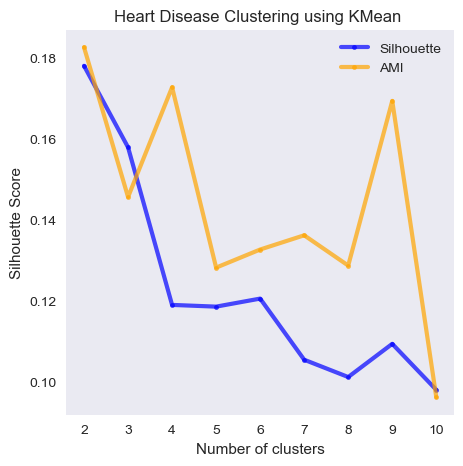

In [85]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,silho_kmm,marker='.', linewidth=3, alpha=0.7,color='blue',label='Silhouette')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlabel('Number of clusters')
# ax2 = ax1.twinx()
ax1.plot(clusters,adjust_mut_info_kmm,color = 'orange',label='AMI',marker='.', linewidth=3, alpha=0.7)
# ax2.set_ylabel('Score')
# ax2.legend(loc='best')
plt.grid()
plt.legend()

plt.title("Heart Disease Clustering using KMean ")
# plt.ylabel('Cumulative explained variance')

Text(0.5, 1.0, 'Heart Disease PCA Variance ')

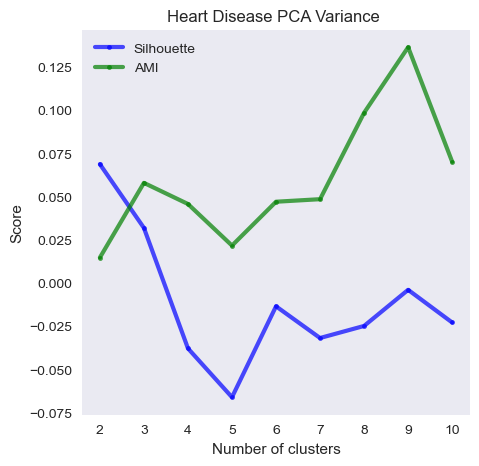

In [86]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,silho_gmm,marker='.', linewidth=3, alpha=0.7,color='blue',label='Silhouette')
ax1.set_ylabel('Score')
ax1.set_xlabel('Number of clusters')
# ax2 = ax1.twinx()
ax1.plot(clusters,adjust_mut_info_gmm,color = 'green',label='AMI',marker='.', linewidth=3, alpha=0.7)
# ax2.set_ylabel('Score')
# ax2.legend(loc='best')
plt.grid()
plt.legend()

plt.title("Heart Disease PCA Variance ")
# plt.ylabel('Cumulative explained variance')

Text(0.5, 1.0, 'Heart Disease PCA Variance ')

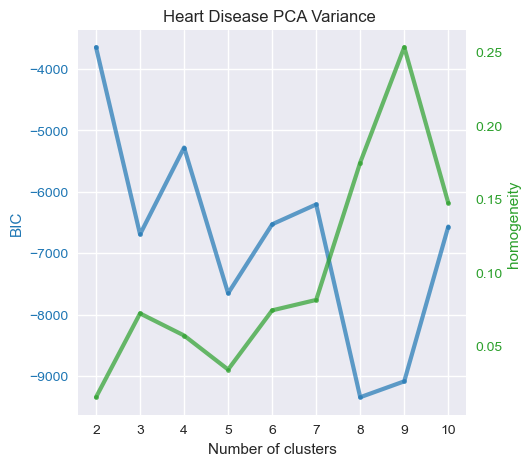

In [88]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,bic_gmm,marker='.', linewidth=3, alpha=0.7,color='tab:blue',label='Silhouette')
ax1.set_ylabel('BIC',color='tab:blue')
ax1.set_xlabel('Number of clusters')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(clusters,homo_gmm,color = 'tab:green',label='AMI',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('homogeneity ',color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='best')
plt.grid()
# plt.legend()

plt.title("Heart Disease PCA Variance ")
# plt.ylabel('Cumulative explained variance')

In [14]:
def get_km(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    return km

def get_gmm(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans',random_state=0)
    gmm.fit(X)
    return gmm
def get_score_kmm(k, X, y):
    km = get_km(k, X)
    y_pred = km.predict(X)
    sse = km.score(X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    hom = homogeneity_score(y, y_pred)
    com = completeness_score(y, y_pred)
    vms = v_measure_score(y, y_pred)
    cal = calinski_harabasz_score(X, y_pred)
    ami_score = ami(y,y_pred)
    return k, sil, db, hom, com, vms, cal, ami_score,sse

def get_score_gmm(k, X, y):
    gmm = get_gmm(k, X)
    y_pred = gmm.predict(X)
    bic = gmm.bic(X)
    aic = gmm.aic(X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    hom = homogeneity_score(y, y_pred)
    com = completeness_score(y, y_pred)
    vms = v_measure_score(y, y_pred)
    cal = calinski_harabasz_score(X, y_pred)
    ami_score = ami(y,y_pred)
    return k, bic, aic, sil, db, hom, com, vms, cal, ami_score

In [15]:
df_kmm_scores = pd.DataFrame([get_score_kmm(k, x, y) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])


In [16]:
df_gmm_scores = pd.DataFrame([get_score_gmm(k, x, y) for k in tqdm(range(2, 11))],
                  columns=['k','bic','aic' ,'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 12.47it/s]


In [15]:
def plot_compare(df, y1, y2, x, fig, ax1):
    ax1.plot(df[x], df[y1], color='tab:red',marker='.', linewidth=2, alpha=0.7)
    ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue',marker='.', linewidth=2, alpha=0.7)
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

def plot_contrast(df, y1, y2, x, fig, ax):
    a = np.array(df[y1])
    b = np.array(df[y2])

    r_min, r_max = df[y1].min(), df[y1].max()
    scaler = MinMaxScaler(feature_range=(r_min, r_max))
    b = scaler.fit_transform(b.reshape(-1, 1))[:,0]

    diff = np.abs(a - b)
    ax.plot(df[x], diff,marker='.', linewidth=3, alpha=0.7)
    ax.set_title('Scaled Absolute Difference')
    ax.set_xlabel(x)
    ax.set_ylabel('absolute difference')
    
def plot_addition(df, y1, y2, x, fig, ax):
    a = np.array(df[y1])
    b = np.array(df[y2])

    r_min, r_max = df[y1].min(), df[y1].max()
    scaler = MinMaxScaler(feature_range=(r_min, r_max))
    b = scaler.fit_transform(b.reshape(-1, 1))[:,0]

    addition = a + b
    ax.plot(df[x], addition,marker='.', linewidth=3, alpha=0.7)
    ax.set_title('Scaled Addition')
    ax.set_xlabel(x)
    ax.set_ylabel('Scaled Addition score')

def plot_result(df, y1, y2, x):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    plot_compare(df, y1, y2, x, fig, axes[0])
#     plot_contrast(df, y1, y2, x, fig, axes[1])
    plot_addition(df, y1, y2, x, fig, axes[1])
    plt.tight_layout()
    return plt

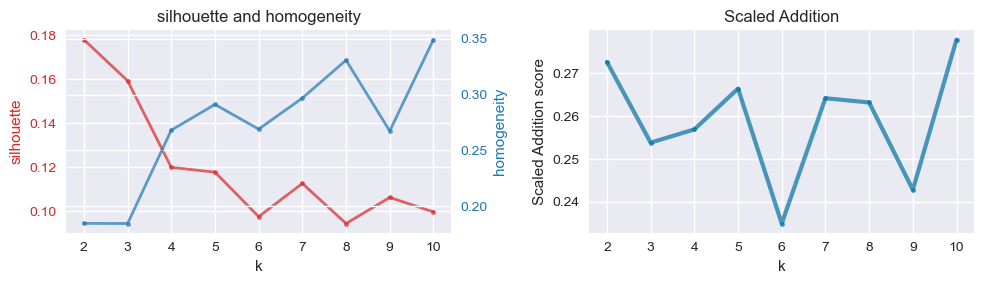

In [21]:
plt =plot_result(df_kmm_scores,'silhouette','homogeneity','k')
plt.savefig(save_folder+"kmm_sil_homo.pdf")

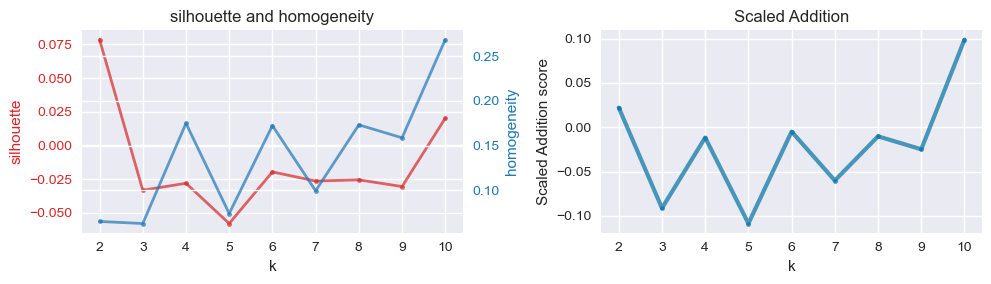

In [22]:
plt = plot_result(df_gmm_scores,'silhouette','homogeneity','k')
plt.savefig(save_folder+"gmm_sil_homo.pdf")

<module 'matplotlib.pyplot' from '/Users/labuser/miniconda3/envs/ml_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

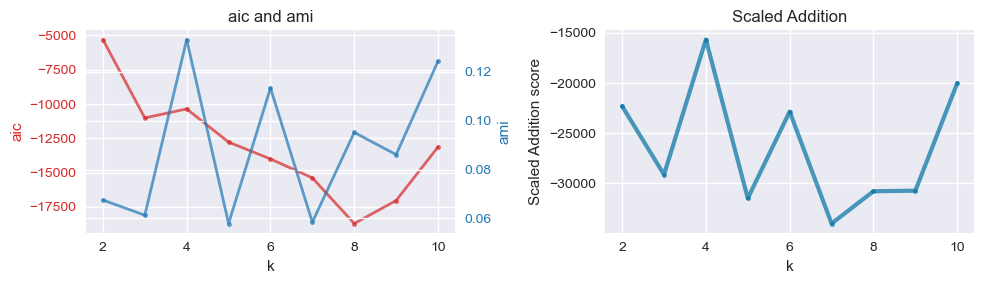

In [23]:
plot_result(df_gmm_scores,'aic','ami','k')

In [16]:
from scipy.spatial.distance import cdist
def plot_cluster(model, X, feature_1=0, feature_2=1, rseed=0, ax=None):
    labels = model.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
#     ax.axis('equal')
    ax.scatter(X[:, feature_1], X[:, feature_2], c=labels, s=40, cmap='viridis', zorder=2)

#     # plot the representation of the KMeans model
#     centers = kmeans.cluster_centers_
#     radii = [cdist(X[labels == i], [center]).max()
#              for i, center in enumerate(centers)]
#     for c, r in zip(centers, radii):
#         ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    return ax 

In [17]:
def plot_cluster(model, X, feature_1=0, feature_2=1, rseed=0, ax=None):
    labels = model.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    for g in np.unique(labels):
        i = np.where(labels == g)
        ax.scatter(X[i,feature_1], X[i,feature_2], label=g)
    return ax 


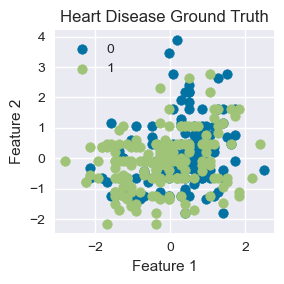

In [85]:
feature_1 = 0
feature_2 = 1
fig, ax = plt.subplots(figsize=(3,3))
for g in np.unique(y):
    i = np.where(y == g)
    ax.scatter(x[i,feature_1], x[i,feature_2], label=g)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Heart Disease Ground Truth')
plt.tight_layout()plt.savefig(save_folder+"cluster_hd_ground.pdf")

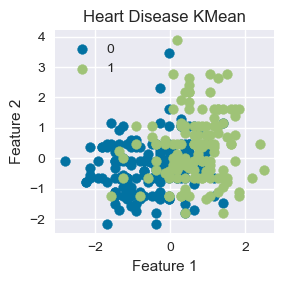

In [86]:
kmeans = KMeans(n_clusters=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(kmeans, x,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Heart Disease KMean')
plt.tight_layout()
plt.savefig(save_folder+"kmm_cluster.pdf")

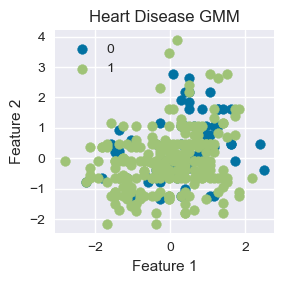

In [87]:
gmm = GaussianMixture(n_components=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(gmm, x,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Heart Disease GMM')
plt.tight_layout()
plt.savefig(save_folder+"gmm_cluster.pdf")

## Spam

In [90]:

clusters = np.arange(2,11)


# spam_sse_kmm = np.zeros((len(clusters),1))
# spam_bic_gmm = np.zeros((len(clusters),1))
spam_bic_gmm = np.zeros((len(clusters),1))

spam_homo_kmm = np.zeros((len(clusters),1))
spam_homo_gmm = np.zeros((len(clusters),1))

spam_comp_kmm = np.zeros((len(clusters),1))
spam_comp_gmm = np.zeros((len(clusters),1))

spam_adjust_mut_info_kmm= np.zeros((len(clusters),1))
spam_adjust_mut_info_gmm= np.zeros((len(clusters),1))

spam_silho_kmm = np.zeros((len(clusters),1))
spam_silho_gmm = np.zeros((len(clusters),1))

for i,c in tqdm(enumerate(clusters)):
    km = KMeans(n_clusters=c,random_state=42).fit(data)
    gmm = GaussianMixture(n_components=c,random_state=42).fit(data)
    
    kmm_y = km.predict(data)
    gmm_y = gmm.predict(data)
    
    
    spam_bic_gmm[i]= gmm.bic(data)
    
    spam_homo_kmm[i] = homogeneity_score(y_data,kmm_y)
    spam_homo_gmm[i] = homogeneity_score(y_data,gmm_y)

    spam_comp_kmm [i] = completeness_score(y_data,kmm_y)
    spam_comp_gmm [i] = completeness_score(y_data,gmm_y)
    
    
    spam_adjust_mut_info_kmm[i] = ami(y_data,kmm_y)
    spam_adjust_mut_info_gmm[i] = ami(y_data,gmm_y)

    spam_silho_kmm[i] = silhouette_score(data,kmm_y)
    spam_silho_gmm[i] = silhouette_score(data,gmm_y)
    
    



9it [00:17,  1.96s/it]


Text(0.5, 1.0, 'Spambase Clustering using KMean ')

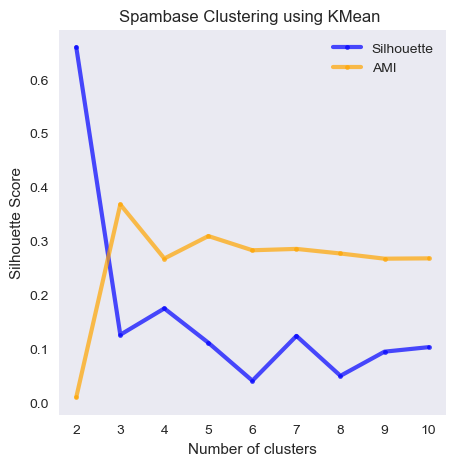

In [92]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,spam_silho_kmm,marker='.', linewidth=3, alpha=0.7,color='blue',label='Silhouette')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlabel('Number of clusters')
# ax2 = ax1.twinx()
ax1.plot(clusters,spam_adjust_mut_info_kmm,color = 'orange',label='AMI',marker='.', linewidth=3, alpha=0.7)
# ax2.set_ylabel('Score')
# ax2.legend(loc='best')
plt.grid()
plt.legend()

plt.title("Spambase Clustering using KMean ")
# plt.ylabel('Cumulative explained variance')

Text(0.5, 1.0, 'Spambase Clustering using KMean GMM ')

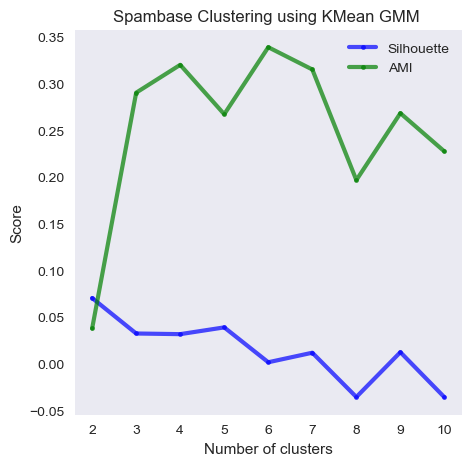

In [93]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,spam_silho_gmm,marker='.', linewidth=3, alpha=0.7,color='blue',label='Silhouette')
ax1.set_ylabel('Score')
ax1.set_xlabel('Number of clusters')
# ax2 = ax1.twinx()
ax1.plot(clusters,spam_adjust_mut_info_gmm,color = 'green',label='AMI',marker='.', linewidth=3, alpha=0.7)
# ax2.set_ylabel('Score')
# ax2.legend(loc='best')
plt.grid()
plt.legend()

plt.title("Spambase Clustering using KMean GMM ")
# plt.ylabel('Cumulative explained variance')

Text(0.5, 1.0, 'Heart Disease PCA Variance ')

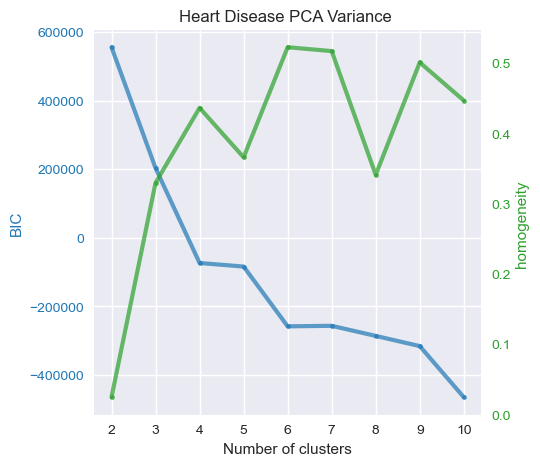

In [94]:
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(clusters,spam_bic_gmm,marker='.', linewidth=3, alpha=0.7,color='tab:blue',label='Silhouette')
ax1.set_ylabel('BIC',color='tab:blue')
ax1.set_xlabel('Number of clusters')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(clusters,spam_homo_gmm,color = 'tab:green',label='AMI',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('homogeneity ',color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='best')
plt.grid()
# plt.legend()

plt.title("Heart Disease PCA Variance ")
# plt.ylabel('Cumulative explained variance')

In [24]:
df_kmm_scores_spam = pd.DataFrame([get_score_kmm(k, data, y_data) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])

In [25]:
df_gmm_scores_spam = pd.DataFrame([get_score_gmm(k, data, y_data) for k in range(2, 11)],
                  columns=['k','bic','aic' ,'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

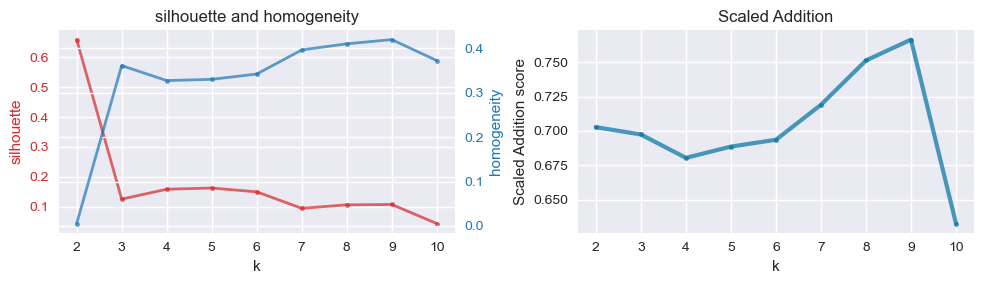

In [29]:
plt = plot_result(df_kmm_scores_spam,'silhouette','homogeneity','k')
plt.savefig(save_folder+"spam_kmm_sil_homo.pdf")

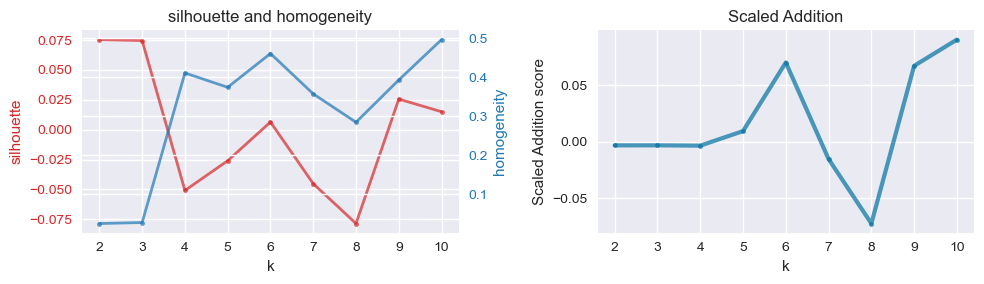

In [30]:
plt = plot_result(df_gmm_scores_spam,'silhouette','homogeneity','k')
plt.savefig(save_folder+"spam_gmm_sil_homo.pdf")

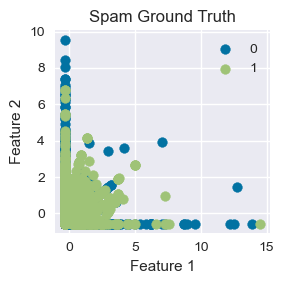

In [88]:
feature_1 = 0
feature_2 = 2
fig, ax = plt.subplots(figsize=(3,3))
for g in np.unique(y_data):
    i = np.where(y_data == g)
    ax.scatter(data[i,feature_1], data[i,feature_2], label=g)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Spam Ground Truth')
plt.tight_layout()
plt.savefig(save_folder+"cluster_spam_ground.pdf")

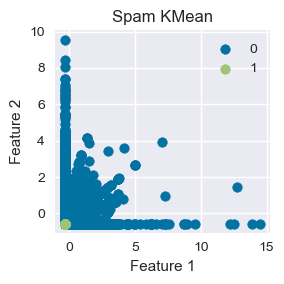

In [89]:
kmeans = KMeans(n_clusters=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(kmeans, data, feature_1=0,feature_2=2,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Spam KMean')
plt.tight_layout()
plt.savefig(save_folder+"spam_kmm_cluster.pdf")


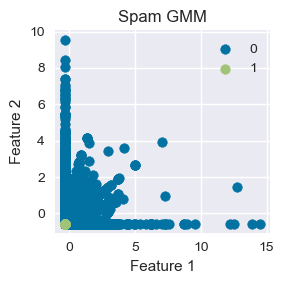

In [90]:
gmm = GaussianMixture(n_components=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(kmeans, data, feature_1=0,feature_2=2,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Spam GMM')
plt.tight_layout()
plt.savefig(save_folder+"spam_gmm_cluster.pdf")


# part 2: Dimensionality Reduction

## PCA

### Heart disease

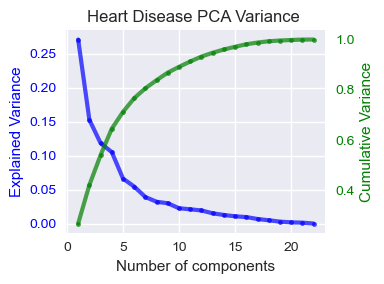

In [65]:
n = x.shape[1] 
pca = PCA(n_components=n).fit(x)

fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(range(1,n+1),pca.explained_variance_ratio_,marker='.', linewidth=3, alpha=0.7,color='blue',label='explained-variance')
# ax1.legend(loc='best')
ax1.set_ylabel('Explained Variance',color='blue')
ax1.set_xlabel('Number of components')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(1,n+1),np.cumsum(pca.explained_variance_ratio_),color = 'green',label='Cumulative-variance',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('Cumulative Variance',color='green')
# ax2.legend(loc='best')
ax2.tick_params(axis='y', labelcolor='green')
plt.grid()
plt.title("Heart Disease PCA Variance ")
# plt.ylabel('Cumulative explained variance')
plt.tight_layout()
plt.savefig(save_folder+"PCA_heart.pdf")


In [18]:
def plot_compare2(df, y1, y2, x, fig, ax1):
    ax1.plot(df[x], df[y1], color='tab:red',marker='.', linewidth=2, alpha=0.7)
#     ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue',marker='.', linewidth=2, alpha=0.7)
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

In [19]:
def plot_result2(df, y1, y2, x):
    fig, axes = plt.subplots(figsize=(4, 3))
    plot_compare2(df, y1, y2, x, fig, axes)
#     plot_contrast(df, y1, y2, x, fig, axes[1])
#     plot_addition(df, y1, y2, x, fig, axes[1])
    plt.tight_layout()
    return plt

In [40]:
pca = PCA(n_components=11,random_state=0)
X_transformed = pca.fit(x).transform(x)

In [41]:


df_kmm_scores_rd = pd.DataFrame([get_score_kmm(k, X_transformed, y) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])

df_gmm_scores_rd = pd.DataFrame([get_score_gmm(k, X_transformed, y) for k in range(2, 11)],
                  columns=['k','bic','aic', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

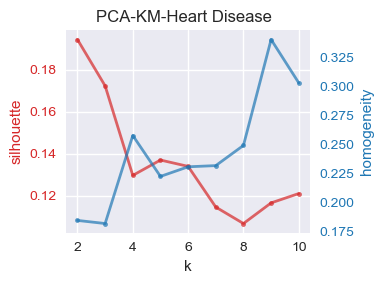

In [66]:
plt =plot_result2(df_kmm_scores_rd,'silhouette','homogeneity','k')
plt.grid()
plt.title("PCA-KM-Heart Disease  ")
plt.tight_layout()
plt.savefig(save_folder+"PCA_KM_Heart_silh.pdf")

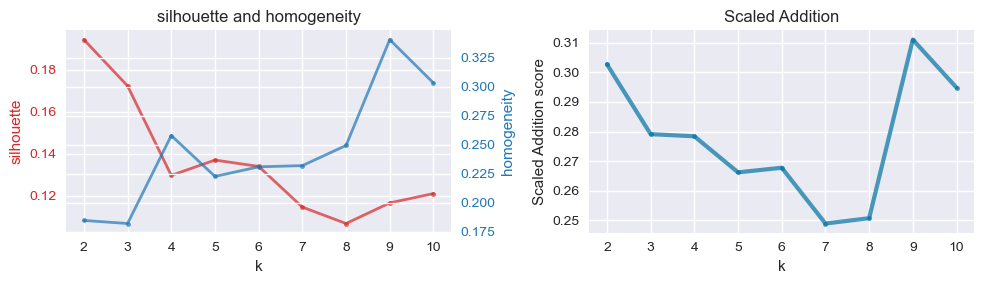

In [43]:
plt =plot_result(df_kmm_scores_rd,'silhouette','homogeneity','k')
# plt.savefig(save_folder+"kmm_sil_homo_rd.pdf")

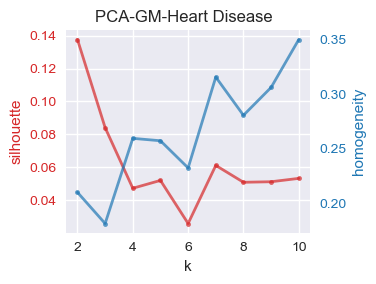

In [67]:
plt =plot_result2(df_gmm_scores_rd,'silhouette','homogeneity','k')
plt.grid()
plt.title("PCA-GM-Heart Disease  ")
plt.tight_layout()
plt.savefig(save_folder+"PCA_GM_Heart_silh.pdf")

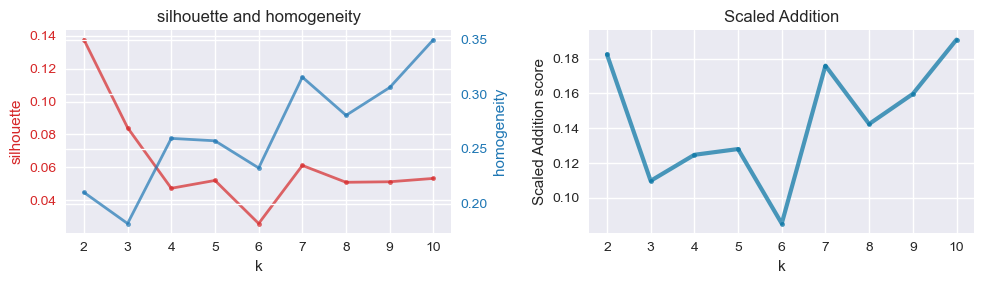

In [45]:
plt = plot_result(df_gmm_scores_rd,'silhouette','homogeneity','k')
# plt.savefig(save_folder+"gmm_sil_homo_rd.pdf")

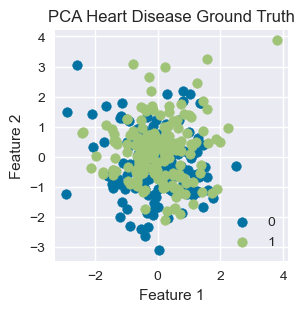

In [48]:
feature_1 = 0
feature_2 = 1
fig, ax = plt.subplots(figsize=(3,3))
for g in np.unique(y):
    i = np.where(y == g)
    ax.scatter(X_transformed[i,2], X_transformed[i,feature_2], label=g)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('PCA Heart Disease Ground Truth')
plt.savefig(save_folder+"PCA_heart_gt.pdf")
# plt.tight_layout()plt.savefig(save_folder+"cluster_hd_ground.pdf")

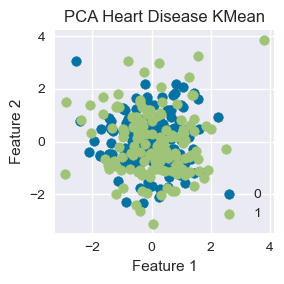

In [49]:
kmeans = KMeans(n_clusters=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(kmeans, X_transformed,feature_1=2,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('PCA Heart Disease KMean')
plt.tight_layout()
plt.savefig(save_folder+"PCA_heart_km.pdf")
# plt.savefig(save_folder+"kmm_cluster.pdf")

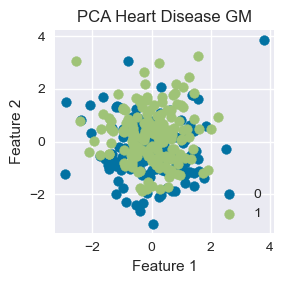

In [50]:
gmm = GaussianMixture(n_components=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(gmm, X_transformed,feature_1=2,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('PCA Heart Disease GM')
plt.tight_layout()
plt.savefig(save_folder+"PCA_heart_gm.pdf")

# plt.savefig(save_folder+"kmm_cluster.pdf")

### Spam

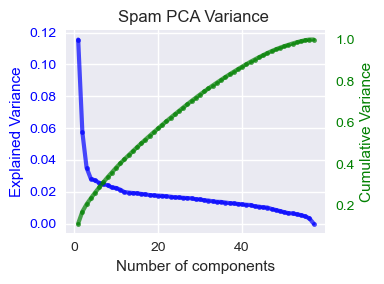

In [69]:
n = data.shape[1] 
pca = PCA(n_components=n).fit(data)

fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(range(1,n+1),pca.explained_variance_ratio_,marker='.', linewidth=3, alpha=0.7,color='blue',label='explained-variance')
# ax1.legend(loc='best')
ax1.set_ylabel('Explained Variance',color='blue')
ax1.set_xlabel('Number of components')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(1,n+1),np.cumsum(pca.explained_variance_ratio_),color = 'green',label='Cumulative-variance',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('Cumulative Variance',color='green')
# ax2.legend(loc='best')
ax2.tick_params(axis='y', labelcolor='green')
plt.grid()
plt.title("Spam PCA Variance ")
plt.tight_layout()
plt.savefig(save_folder+"PCA_spam.pdf")
# plt.ylabel('Cumulative explained variance')

In [58]:
pca = PCA(n_components=35,random_state=0)
X_transformed = pca.fit(data).transform(data)

In [59]:


df_kmm_scores_rd_sapm = pd.DataFrame([get_score_kmm(k, X_transformed, y_data) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])

df_gmm_scores_rd_spam = pd.DataFrame([get_score_gmm(k, X_transformed, y_data) for k in range(2, 11)],
                  columns=['k','bic','aic', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

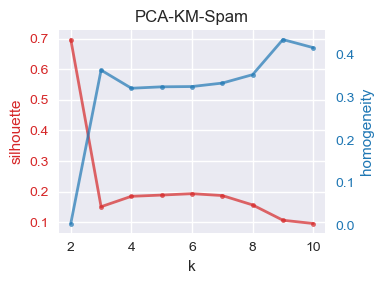

In [70]:
plt =plot_result2(df_kmm_scores_rd_sapm,'silhouette','homogeneity','k')
plt.grid()
plt.title("PCA-KM-Spam")
plt.tight_layout()
plt.savefig(save_folder+"PCA_KM_spam_silh.pdf")

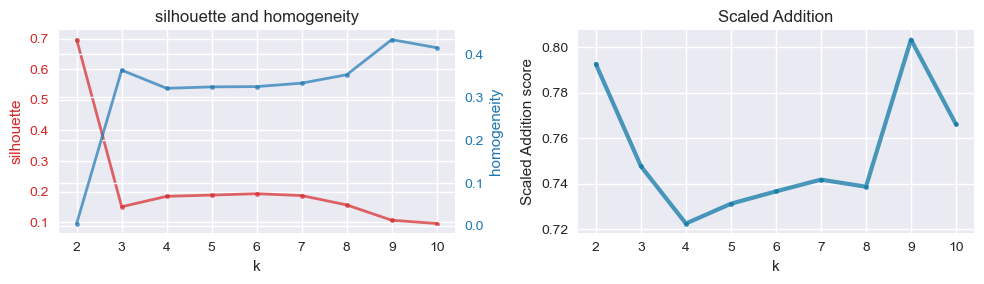

In [61]:
plt =plot_result(df_kmm_scores_rd_sapm,'silhouette','homogeneity','k')
# plt.savefig(save_folder+"kmm_sil_homo_rd_spam.pdf")

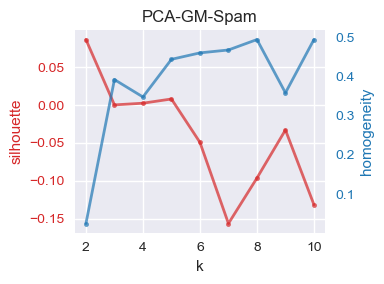

In [71]:
plt =plot_result2(df_gmm_scores_rd_spam,'silhouette','homogeneity','k')
plt.grid()
plt.title("PCA-GM-Spam")
plt.tight_layout()
plt.savefig(save_folder+"PCA_GM_spam_silh.pdf")

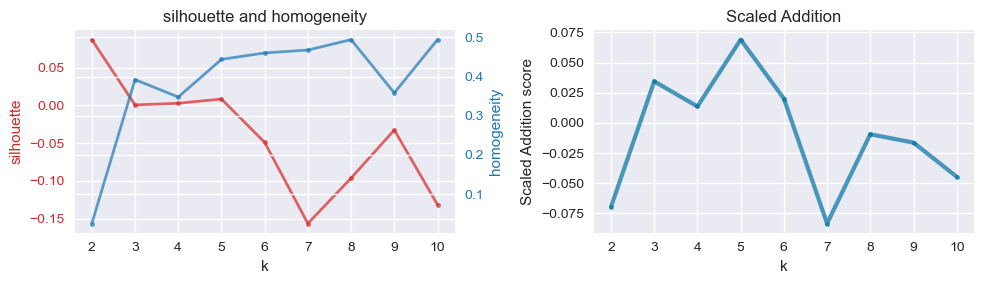

In [63]:
plt =plot_result(df_gmm_scores_rd_spam,'silhouette','homogeneity','k')
# plt.savefig(save_folder+"gmm_sil_homo_rd_spam.pdf")

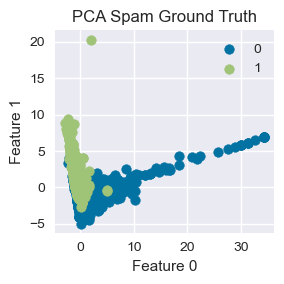

In [72]:
feature_1 = 0
feature_2 = 1
fig, ax = plt.subplots(figsize=(3,3))
for g in np.unique(y_data):
    i = np.where(y_data == g)
    ax.scatter(X_transformed[i,feature_1], X_transformed[i,feature_2], label=g)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.tight_layout()
plt.title('PCA Spam Ground Truth')
plt.tight_layout()
plt.savefig(save_folder+"PCA_spam_gt.pdf")

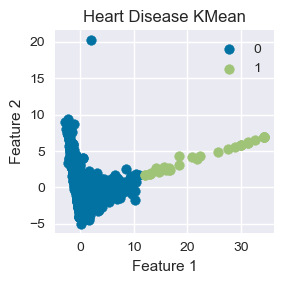

In [73]:
kmeans = KMeans(n_clusters=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(kmeans, X_transformed,feature_1=0,feature_2=1,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Heart Disease KMean')
plt.tight_layout()
plt.savefig(save_folder+"PCA_spam_km.pdf")

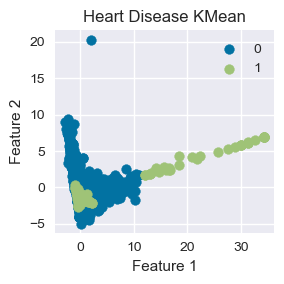

In [74]:
gmm = GaussianMixture(n_components=2, random_state=0)
fig, ax1 = plt.subplots(figsize=(3,3))
ax1 = plot_cluster(gmm, X_transformed,feature_1=0,feature_2=1,ax = ax1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title('Heart Disease KMean')
plt.tight_layout()
plt.savefig(save_folder+"PCA_spam_gm.pdf")

## ICA

### Heart

In [20]:
start = time.time()
ica = FastICA()
X_transformed = ica.fit(x).transform(x)
print("Elapsed time: ", time.time() - start)
kurtosis_ = [-abs(kurtosis(X_transformed[:,i])) for i in range(X_transformed.shape[1])]
kurtosis_.sort()
kurtosis_ = -1*np.array(kurtosis_)
order = kurtosis_.argsort()
X_transformed_sorted = X_transformed[:,order]

normalized_kurtosis = np.array(kurtosis_)/ sum(kurtosis_)


Elapsed time:  0.032998085021972656


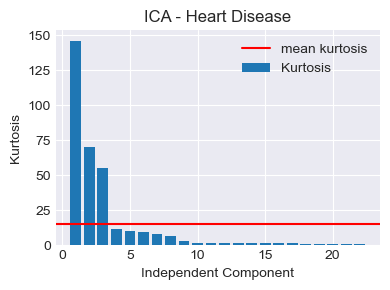

In [21]:

plt.figure(figsize=(4,3))
plt.bar(range(1, X_transformed_sorted.shape[1]+1), kurtosis_,label='Kurtosis')
plt.axhline(y = np.array(kurtosis_).mean(), color = 'r', linestyle = '-',label='mean kurtosis')
plt.legend()
plt.xlabel("Independent Component")
plt.ylabel("Kurtosis")
plt.title("ICA - Heart Disease")
plt.tight_layout()
# plt.tick_params(labelsize = 10)
# plt.savefig("graphs_DR/wine_ICA_kurtosis.png", pad_inches = 0.01,  bbox_inches = 'tight')

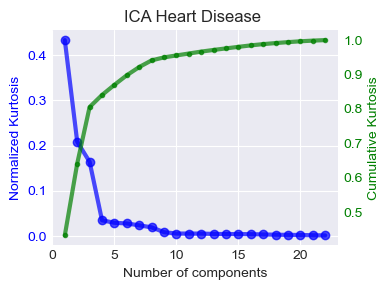

In [22]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(range(1, X_transformed_sorted.shape[1]+1),normalized_kurtosis,marker='o', linewidth=3, alpha=0.7,color='blue',label='explained-variance')
# ax1.legend(loc='best')
ax1.set_ylabel('Normalized Kurtosis',color='blue')
ax1.set_xlabel('Number of components')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(1, X_transformed_sorted.shape[1]+1),np.cumsum(normalized_kurtosis),color = 'green',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('Cumulative Kurtosis',color='green')
# ax2.axhline(y = 0.95, color = 'r', linestyle = '--',label='0.95')
ax2.tick_params(axis='y', labelcolor='green')
plt.grid()
# plt.legend(loc='best')
plt.title("ICA Heart Disease ")
plt.tight_layout()
plt.savefig(save_folder+"ICA_heart.pdf")

In [202]:
n_features = 8
ica = FastICA(random_state=0)
X_transformed = ica.fit(x).transform(x)
kurtosis_ = [-abs(kurtosis(X_transformed[:,i])) for i in range(X_transformed.shape[1])]
order = np.array(kurtosis_).argsort()
print(order[:n_features])
X_transformed = X_transformed[:,order[:n_features]]

[ 8  0 14 20 10  7  2  1]


In [203]:
df_kmm_scores_ica = pd.DataFrame([get_score_kmm(k, X_transformed, y) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])

df_gmm_scores_ica = pd.DataFrame([get_score_gmm(k, X_transformed, y) for k in range(2, 11)],
                  columns=['k','bic','aic', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

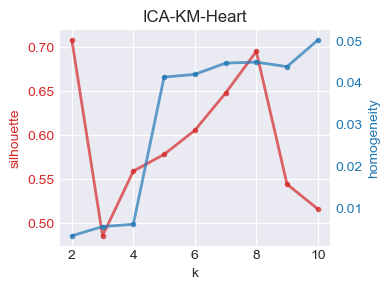

In [204]:
plt =plot_result2(df_kmm_scores_ica,'silhouette','homogeneity','k')
plt.grid()
plt.title("ICA-KM-Heart")
plt.tight_layout()
plt.savefig(save_folder+"ICA_KM_heart_silh.pdf")

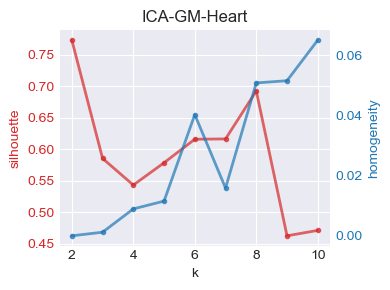

In [205]:
plt =plot_result2(df_gmm_scores_ica,'silhouette','homogeneity','k')
plt.grid()
plt.title("ICA-GM-Heart")
plt.tight_layout()
plt.savefig(save_folder+"ICA_GM_heart_silh.pdf")

### spam

In [23]:
start = time.time()
ica = FastICA()
X_transformed = ica.fit(data).transform(data)
print("Elapsed time: ", time.time() - start)
kurtosis_ = [-abs(kurtosis(X_transformed[:,i])) for i in range(X_transformed.shape[1])]
kurtosis_.sort()
kurtosis_ = -1*np.array(kurtosis_)
order = kurtosis_.argsort()
X_transformed_sorted = X_transformed[:,order]

normalized_kurtosis = np.array(kurtosis_)/ sum(kurtosis_)

Elapsed time:  0.19788885116577148


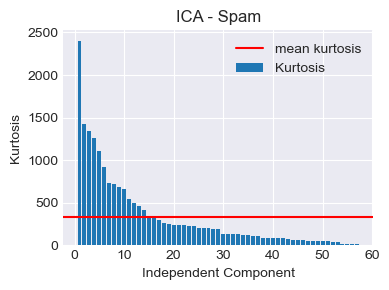

In [24]:



plt.figure(figsize=(4,3))
plt.bar(range(1, X_transformed.shape[1]+1), kurtosis_,label='Kurtosis')
plt.axhline(y = np.array(kurtosis_).mean(), color = 'r', linestyle = '-',label='mean kurtosis')
plt.legend()
plt.xlabel("Independent Component")
plt.ylabel("Kurtosis")
plt.title("ICA - Spam")
plt.tight_layout()
# plt.tick_params(labelsize = 10)
# plt.savefig("graphs_DR/wine_ICA_kurtosis.png", pad_inches = 0.01,  bbox_inches = 'tight')

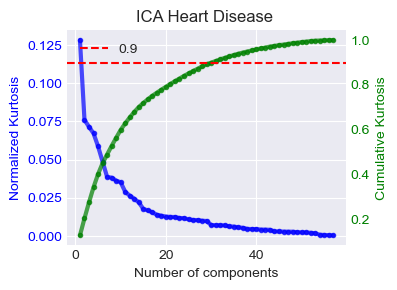

In [25]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(range(1, X_transformed.shape[1]+1),normalized_kurtosis,marker='.', linewidth=3, alpha=0.7,color='blue',label='explained-variance')
# ax1.legend(loc='best')
ax1.set_ylabel('Normalized Kurtosis',color='blue')
ax1.set_xlabel('Number of components')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(1, X_transformed.shape[1]+1),np.cumsum(normalized_kurtosis),color = 'green',marker='.', linewidth=3, alpha=0.7)
ax2.set_ylabel('Cumulative Kurtosis',color='green')
ax2.axhline(y = 0.9, color = 'r', linestyle = '--',label='0.9')
ax2.tick_params(axis='y', labelcolor='green')
plt.grid()
plt.legend(loc='best')
plt.title("ICA Heart Disease ")
plt.tight_layout()
plt.savefig(save_folder+"ICA_spam.pdf")

In [218]:
n_features = 30
ica = FastICA(random_state=0)
X_transformed = ica.fit(data).transform(data)
kurtosis_ = [-abs(kurtosis(X_transformed[:,i])) for i in range(X_transformed.shape[1])]
order = np.array(kurtosis_).argsort()
# print(order[:n_features])
X_transformed = X_transformed[:,order[:n_features]]

In [219]:
df_kmm_scores_ica_spam = pd.DataFrame([get_score_kmm(k, X_transformed, y_data) for k in range(2, 11)],
                  columns=['k', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami','sse'])

df_gmm_scores_ica_spam = pd.DataFrame([get_score_gmm(k, X_transformed, y_data) for k in range(2, 11)],
                  columns=['k','bic','aic', 'silhouette',
                           'davies', 'homogeneity',
                           'completeness', 'vmeasure', 'calinski','ami'])

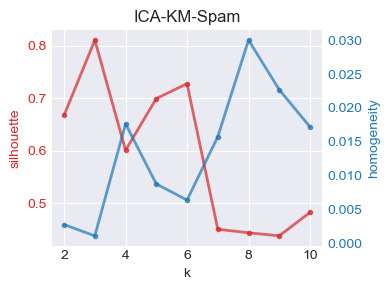

In [220]:
plt =plot_result2(df_kmm_scores_ica_spam,'silhouette','homogeneity','k')
plt.grid()
plt.title("ICA-KM-Spam")
plt.tight_layout()
plt.savefig(save_folder+"ICA_KM_spam_silh.pdf")

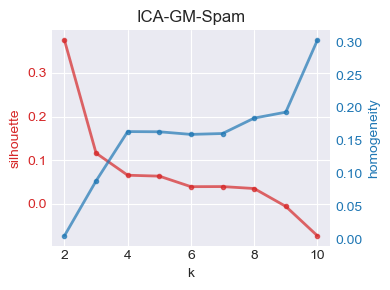

In [221]:
plt =plot_result2(df_gmm_scores_ica_spam,'silhouette','homogeneity','k')
plt.grid()
plt.title("ICA-GM-Spam")
plt.tight_layout()
plt.savefig(save_folder+"ICA_GM_spam_silh.pdf")

### RP

In [29]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

  
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    # reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    reconstructed = (np.matmul(np.matmul(p,W),(X.T))).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

### Heart Disease

In [46]:
n_components = np.arange(1,62,3)
corr_hd = np.zeros((len(n_components),3))
recons_err =  np.zeros((len(n_components),3))
for i,n in enumerate(n_components):
    start = time.time()
    tmp_corr = np.zeros(10)
    tmp_recons = np.zeros(10)
  
    for j in range(10):
        rp = SparseRandomProjection(n_components=n)
        rp.fit(x)
        tmp_corr[j] = pairwiseDistCorr(rp.transform(x), x)
        tmp_recons[j] = reconstructionError(rp,x)

    corr_hd[i] = [np.max(tmp_corr), np.mean(tmp_corr), np.std(tmp_corr)]
    recons_err[i] = [np.max(tmp_recons), np.mean(tmp_recons), np.std(tmp_recons)]

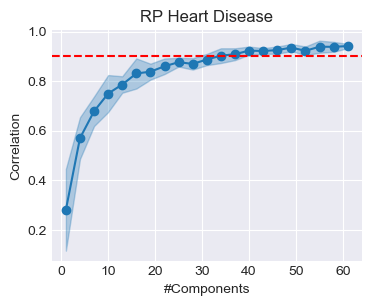

In [55]:
fig, ax1 = plt.subplots(figsize=(4,3))
# plt.plot(n_components, corr[:,0], label="Best")
ax1.plot(n_components, corr_hd[:,1], 'o-', color="tab:blue")
ax1.fill_between(n_components, corr_hd[:,1] - corr_hd[:,2],corr_hd[:,1] + corr_hd[:,2], alpha=0.3,color="tab:blue")
plt.axhline(y = 0.9, color = 'r', linestyle = '--')

plt.ylabel("Correlation")
plt.xlabel("#Components")
plt.title("RP Heart Disease")

# ax1.set_ylabel("Correlation",color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2 = ax1.twinx()
# ax2.plot(n_components, recons_err[:,1], 'o-', color="tab:green")
# ax2.fill_between(n_components, recons_err[:,1] - recons_err[:,2],recons_err[:,1] + recons_err[:,2], alpha=0.3,color="tab:green")
# plt.xlabel("#Components")
# ax2.set_ylabel("Reconstructed Error",color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# plt.grid()
plt.savefig(save_folder+"rp_corr_hd.pdf")

### spam

In [42]:
n_components = np.arange(1,62,3)
corr = np.zeros((len(n_components),3))
recons_err =  np.zeros((len(n_components),3))
for i,n in tqdm(enumerate(n_components)):
    start = time.time()
    tmp_corr = np.zeros(10)
    tmp_recons = np.zeros(10)
  
    for j in range(10):
        rp = SparseRandomProjection(n_components=n)
        rp.fit(data)
        tmp_corr[j] = pairwiseDistCorr(rp.transform(data), data)
        tmp_recons[j] = reconstructionError(rp,data)

    corr[i] = [np.max(tmp_corr), np.mean(tmp_corr), np.std(tmp_corr)]
    recons_err[i] = [np.max(tmp_recons), np.mean(tmp_recons), np.std(tmp_recons)]

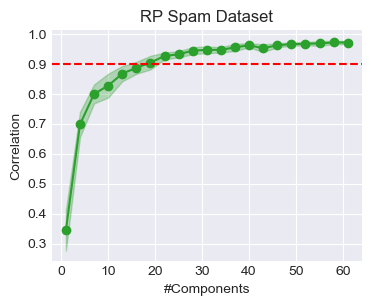

In [54]:
fig, ax1 = plt.subplots(figsize=(4,3))
# plt.plot(n_components, corr[:,0], label="Best")
ax1.plot(n_components, corr[:,1], 'o-', color="tab:green")
ax1.fill_between(n_components, corr[:,1] - corr[:,2],corr[:,1] + corr[:,2], alpha=0.3,color="tab:green")
# ax1.plot(n_components, corr_hd[:,1], 'o-', color="tab:blue")
# ax1.fill_between(n_components, corr_hd[:,1] - corr_hd[:,2],corr_hd[:,1] + corr_hd[:,2], alpha=0.3,color="tab:blue")
plt.ylabel("Correlation")
plt.xlabel("#Components")
plt.title("RP Spam Dataset")
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
# ax1.set_ylabel("Correlation",color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2 = ax1.twinx()
# ax2.plot(n_components, recons_err[:,1], 'o-', color="tab:green")
# ax2.fill_between(n_components, recons_err[:,1] - recons_err[:,2],recons_err[:,1] + recons_err[:,2], alpha=0.3,color="tab:green")
# plt.xlabel("#Components")
# ax2.set_ylabel("Reconstructed Error",color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# plt.grid()
plt.savefig(save_folder+"rp_corr_spam.pdf")

## RandomForest 

### Heart

In [57]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
hd_feature_importances = rfc.fit(x,y).feature_importances_
hd_feature_importances = np.sort(hd_feature_importances)[::-1]

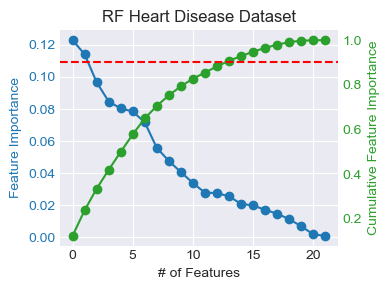

In [86]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(hd_feature_importances, 'o-', color="tab:blue")
plt.title("RF Heart Disease Dataset")
ax1.set_ylabel("Feature Importance",color='tab:blue')
ax1.set_xlabel("# of Features")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(np.cumsum(hd_feature_importances), 'o-', color="tab:green")
ax2.axhline(y = 0.9, color = 'r', linestyle = '--')
ax2.set_ylabel("Cumulative Feature Importance",color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.grid()
# ax2.set_xlabel("Number of features")
plt.tight_layout()
plt.savefig(save_folder+"rf_fi_hd.pdf")

### Spam

In [77]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
spam_feature_importances = rfc.fit(data,y_data).feature_importances_
spam_feature_importances = np.sort(spam_feature_importances)[::-1]

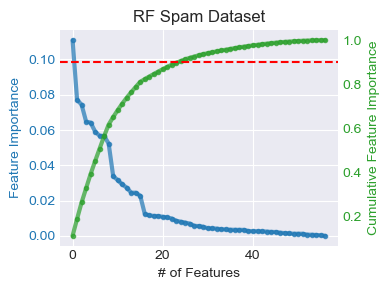

In [85]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(spam_feature_importances, '.-', color="tab:blue",linewidth=3,alpha=0.7)
plt.title("RF Spam Dataset")
ax1.set_ylabel("Feature Importance",color='tab:blue')
ax1.set_xlabel("# of Features")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(np.cumsum(spam_feature_importances), '.-', color="tab:green",linewidth=3,alpha=0.7)
ax2.axhline(y = 0.9, color = 'r', linestyle = '--')
ax2.set_ylabel("Cumulative Feature Importance",color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.grid()
# ax2.set_xlabel("Number of features")
plt.tight_layout()
plt.savefig(save_folder+"rf_fi_spam.pdf")